<a href="https://colab.research.google.com/github/JonathanMartignon/Datos_Masitvos/blob/master/Proyecto_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Proyecto 10**

* Martiñón Luna Jonathan José

Fecha de Entrega: 24 Abril, 2020

---

Genera un buscador de imágenes usando índice inverso y visualiza las imágenes con mayor similitud de Jaccard, MinMax y Coseno. Para su implementación debes usar listas de Python y NumPy y la base de datos a emplear es:  imágenes de edificios de París. 

https://www.robots.ox.ac.uk/~vgg/data/parisbuildings/

---

Las bolsas ya están divididas en entrenamiento (dogs_ent.corpus y paris_ent.corpus) y validación (dogs_val.corpus y paris_ent.corpus).
Se incluye la lista de imágenes para cada conjunto (de entrenamiento y validación)

---

El formato de las bolsas es el siguiente:

size_of_list_1 item1_1:freq1_1 item2_1:freq2_1 ...

size_of_list_1 item1_2:freq1_22 item2_2:freq2_2 ...

...                        ...

size_of_list_N item1_N:freq1_N item2_N:freq2_N ...


Por ejemplo:

6 3:9 4:8 7:5 12:1 16:5 18:5 

3 2:7 3:4 8:5

4 1:9 2:10 16:8 17:10

4 10:10 11:4 15:8 16:3

3 0:1 14:9 15:10

---



Inicio

Creando las carpetas para almacenar

In [0]:
!mkdir /content/Data
!mkdir /content/Data/Entrenamiento /content/Data/Validacion /content/Data/Imagenes

Descargando nuestros datos

In [2]:
!wget -O Data.zip https://www.dropbox.com/sh/8rf98easjw4dvt6/AADUGsVaUW5nvAk4CESAJQf5a?dl=0/lista_ent_paris.txt?dl=1
!wget -O Imagenes.tgz http://www.robots.ox.ac.uk/~vgg/data/parisbuildings/paris_1.tgz
!wget -O Imagenes2.tgz http://www.robots.ox.ac.uk/~vgg/data/parisbuildings/paris_2.tgz

--2020-04-22 10:25:50--  https://www.dropbox.com/sh/8rf98easjw4dvt6/AADUGsVaUW5nvAk4CESAJQf5a?dl=0/lista_ent_paris.txt?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.9.1, 2620:100:601f:1::a27d:901
Connecting to www.dropbox.com (www.dropbox.com)|162.125.9.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /sh/raw/8rf98easjw4dvt6/AADUGsVaUW5nvAk4CESAJQf5a [following]
--2020-04-22 10:25:50--  https://www.dropbox.com/sh/raw/8rf98easjw4dvt6/AADUGsVaUW5nvAk4CESAJQf5a
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucbe4783910cd2127f54f03e404f.dl.dropboxusercontent.com/zip_download_get/AZv8PYDu_-Kk91UHpUICiuHpAnUv6plevPpELZxH-u9nKlXAmi2a3nAyTOb9P6d68n9e54O6TEWFVYXyegoQMp9VKtTa1KmkF5wWeDiK1POSPA [following]
--2020-04-22 10:25:51--  https://ucbe4783910cd2127f54f03e404f.dl.dropboxusercontent.com/zip_download_get/AZv8PYDu_-Kk91UHpUICiuHpAnUv6plevPpELZxH-u9nKlXAmi2a3nAyTOb

Descomprimiendo


In [3]:
!unzip Data.zip
!tar xzf Imagenes.tgz -C /content/Data/Imagenes
!tar xzf Imagenes2.tgz

Archive:  Data.zip
mapname:  conversion of  failed
 extracting: paris_val.corpus        
 extracting: paris_ent.corpus        
 extracting: lista_val_paris.txt     
 extracting: lista_ent_paris.txt     


Moviendo nuestros archivos

In [0]:
!mv paris_val.corpus /content/Data/Validacion/paris_val.txt
!mv lista_val_paris.txt /content/Data/Validacion
!mv paris_ent.corpus /content/Data/Entrenamiento/paris_ent.txt
!mv lista_ent_paris.txt /content/Data/Entrenamiento
!mv paris/museedorsay /content/Data/Imagenes/paris
!mv paris/notredame /content/Data/Imagenes/paris
!mv paris/pantheon /content/Data/Imagenes/paris
!mv paris/pompidou /content/Data/Imagenes/paris
!mv paris/sacrecoeur /content/Data/Imagenes/paris
!mv paris/triomphe /content/Data/Imagenes/paris

Eliminando los comprimidos que ya no nos sirven

In [0]:
# !rm -r /content/Data # A veces me equivocaba y debía eliminar la carpeta entera
!rm /content/Data.zip
!rm /content/Imagenes.tgz
!rm /content/Imagenes2.tgz
!rm -r /content/sample_data # Me 'hacía mosca' esa carpeta
!rm -r /content/paris 

Una vez que ya tenemos nuestros archivos cargados, podemos proceder a trabajar.
Empezamos por cargar nuestras funciones de similitud (Extraídas de los notebooks de clase)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import Counter

In [0]:
#Esta función nos ayudará a igualar listas de diferentes dimensiones
# a = [1,2]
# b = [1,2,3,4]
# aux = [[1,2],[1,2,3,4]]
# Rellena_ceros(aux)
# aux = [[1,2,0,0],[1,2,3,4]]
def Rellena_ceros(listas):
  
  if len(listas[0]) < len(listas[1]):
    for i in range(len(listas[0]),len(listas[1])): # comenzamos en el final del anterior
      listas[0].append(0)
  else:
    for i in range(len(listas[1]),len(listas[0])):
      listas[1].append(0)

  return listas

In [0]:
# Modificamos internamente, pues le enviamos listas
def similitud_coseno(x, y):
  aux = [x,y]
  aux = Rellena_ceros(aux)
  x = np.asarray(aux[0])
  y = np.asarray(aux[1])
  return (x @ y) / (np.sqrt(x @ x) * np.sqrt(y @ y))

In [0]:
def similitud_jaccard(x, y):
  inter = 0
  for e in x:
    if e in y:
      inter += 1

  return inter / (len(x) + len(y) - inter)

In [0]:
def similitud_minmax(x, y):
  aux = [x,y]
  aux = Rellena_ceros(aux)
  x = np.asarray(aux[0])
  y = np.asarray(aux[1])
  c = np.vstack((x,y))
  mn = np.sum(np.min(c, axis=0))
  mx = np.sum(np.max(c, axis=0))
  return mn / mx

In [0]:
# Probando las distancias entre listas de diferente dimension
b = [1,2,3]
a = [1,2,3,4,5,6]

In [117]:
# Coseno
similitud_coseno(a,b)

0.3922322702763681

In [118]:
# Jaccard
similitud_jaccard(a,b)

0.3333333333333333

In [119]:
# MinMax
similitud_minmax(a,b)

0.2857142857142857

---

Esta función se encargará de mostrar nuestra imagen a partir del nombre sin la necesidad de la extensión, es decir, tal y como vienen en nuestras listas

---

In [0]:
def obten_imagen(name):

  ruta = '/content/Data/Imagenes/paris/'
  carpeta = name.split('_')[1] + '/'
  ruta += carpeta + name +'.jpg'
  
  # print(ruta)

  imagen = plt.imread(ruta)
  plt.imshow(imagen)
  plt.title(name)
  plt.axis('off')
  plt.show()

Así mismo, extraemos nuestra clase de Índice inverso, teniendo en cuenta que no hacemos uso de matrices de disperción, nos vemos en la nececidad de modificar la clase

In [0]:
class IndiceInverso:

  # Me parece que esta función no es necesario que se modifique, pues 
  # En la clase original se convierte el csr en listas, cosa que en este
  # Caso, ya está hecho
  def  __getitem__(self, idx):
    print(f"La pocisión {idx} contiene la característica {self.Ind_Car[idx]}")
    return self.ifs[idx]

  # Esta función igualmente es llamada después de la conversión a listas
  def recupera(self, l):
    # Creo que esta función recibe la bolsa de características de una imagen
    # Y simplemente recupera las imágenes en los que están presentes cada una
    imgs = Counter()
    for Car in l:
      # Ya tenemos la característica, necesitamos su pocisión
      # En nuestro ifs
      self.Index = self.Ind_Car.index(Car)
      #Ahora sí la podemos llamar
      imgs.update(self.ifs[self.Index])

    return imgs

  # Anteriormente from_csr, no se me ocurría un nombre adecuado
  def Add(self, Data): 

    # Data es la lista de listas con cada bolsa


    # Me parece que de acuerdo a lo observado, en el comportamiento del
    # Código anterior, lo que se almacena es el documento (i)
    # De acuerdo a la característica que pertenecen (j)
    # self.ifs[j].append(i)
    # Claro, estaban en otro formato, por lo que había que convertir, sin embargo
    # Este no es el caso, se puede realizar directamente

    # A decir verdad, no entiendo bien cuántas carácterísticas voy a tener,
    # Por lo que es una lista abierta

    

    #Este ciclo se encargará de  orgranizar las características en orden
    # Para evitar tener la 1, 2, 132, y que se tenga mucha distancia
    # Si se ordenan en un arreglo, sabremos que la posición 0 corresponde 
    # a la característica 1, la posición 2 a la característica 2, la posición
    # 3 a la característica 132 y así nos evitamos los espacios de memoria
    # Vacíos

    self.Ind_Car =[] 
    self.ifs = [[]] # Como será una lista de listas, lo inicializamos con una lista incluida

    # i = 0
    for i,bolsa in enumerate(Data):
      print("Analizando bolsa:",i+1)
      #Evaluamos cada bolsa en los datos

      for Car in bolsa:

        #Evaluamos cada característica de la bolsa
        if len(self.Ind_Car) == 0:

          # La primera la añadimos automáticamente
          self.Ind_Car.append(Car)
          # así mismo, sabemos que pertenece al documento 1, por lo que
          # lo añadimos directamente en la otra lista
          self.ifs[0].append(i)  
        else:

          if Car in self.Ind_Car:
            # En caso de que la característica ya esté no hacemos nada
            pass
          else:
          
            # Si no está en nuestra lista, la añadimos
            self.Ind_Car.append(Car)
            # Y añadimos un nuevo espacio (Lista) a nuestro arreglo de índices
            self.ifs.append([])
          
          #Ya que sabemos que está en la lista y ya tenemos un espacio 
          # en el otro arreglo, simplemente añadimos la imagen
          # Con su característica
          self.Index = self.Ind_Car.index(Car) # Obtenemos la pocisión de la característica
          self.ifs[self.Index].append(i)  # Añadimos la imagen a la característica
     

Extraemos la función que lee las bolsas, recordamos que a diferencia del ejemplo visto en clase, nuestras bolsas se encuentran solo en 2 archivos, entrenamiento y validación, a diferencia del ejemplo donde teníamos una carpeta de entrenamiento y las bolsas separadas en archivos .txt

In [0]:
def lee_bolsa(ruta):
  b = []
  with open(ruta, 'r') as f:

    for l in f.readlines():

      # print(l) # En caso de querer ver la bolsa que se está trabajando
      aux = l.split()[1:] # Me parece que no usamos la longitud de la bolsa
      new_list = [] # Lista auxiliar que recogerá los items de cada bolsa

      for item in aux:

        item_split = item.split(':')
        new_list.append(int(item_split[0])) # Sólo tomaremos el item, la frecuencia no

        if int(item_split[1]) != 1:

          print("Valor diferente a 1 ->",item_split[1]) 
          # Las frecuencias a mi parecer siempre eran 1
          # Quería ver si alguna era diferente
          # Cosa que no sucedió

      b.append(new_list) # Añadimos la lista con los items de cada una de las bolsas

  return b

Modificamos La función que lee las bolsas para que lea las listas

In [0]:
def lee_lista(ruta):
  b = []
  with open(ruta, 'r') as f:
    for l in f.readlines():
      l = l[:-1] # El último elemento que guardaba era un salto de línea, lo eliminamos "\n"
      b.append(l)
  return b

---
Leyendo Las bolsas 

---

In [0]:
bolsas_entrenamiento = lee_bolsa('/content/Data/Entrenamiento/paris_ent.txt')

In [0]:
bolsas_validacion = lee_bolsa('/content/Data/Validacion/paris_val.txt')

---
Leyendo las listas

---

In [0]:
Lista_Entr = lee_lista('/content/Data/Entrenamiento/lista_ent_paris.txt')

In [0]:
Lista_Val = lee_lista('/content/Data/Validacion/lista_val_paris.txt')

---
Verificando los datos en cada una de nuestras listas y bolsas

---

In [22]:
print("Contamos con",len(bolsas_entrenamiento),"bolsas de entrenamiento")
print("Los 3 primeros items de la primera bolsa son:",bolsas_entrenamiento[0][0:3])

Contamos con 5112 bolsas de entrenamiento
Los 3 primeros items de la primera bolsa son: [129026, 147458, 176134]


In [23]:
print("Contamos con",len(bolsas_validacion),"bolsas de validación")
print("Los 3 primeros items de la primera bolsa son:",bolsas_validacion[0][0:3])

Contamos con 1278 bolsas de validación
Los 3 primeros items de la primera bolsa son: [225282, 149508, 233476]


In [24]:
print("Nuestra lista de entrenamiento tiene",len(Lista_Entr),"elementos")
print("Las primeras 3 imágenes son:",Lista_Entr[0:3])

Nuestra lista de entrenamiento tiene 5112 elementos
Las primeras 3 imágenes son: ['paris_defense_000534', 'paris_general_000904', 'paris_general_001104']


In [25]:
print("Nuestra lista de validación tiene",len(Lista_Val),"elementos")
print("Las primeras 3 imágenes son:",Lista_Val[0:3])

Nuestra lista de validación tiene 1278 elementos
Las primeras 3 imágenes son: ['paris_moulinrouge_000529', 'paris_museedorsay_000353', 'paris_pantheon_000517']


---
Llegados a este punto hemos verificado que contamos con la misma cantidad de elementos dentro de nuestras bolsas con sus correspondientes listas, así mismo, hemos corroborado la forma de nuestras bolsas y lo elementos de las mismas.

Realizamos un histograma de nuestras características en nuestro conjunto de entrenamiento

---

In [0]:
hist = np.array(bolsas_entrenamiento[0])
for i in range(1,len(bolsas_entrenamiento)):
  np.append(hist, bolsas_entrenamiento[i])


In [0]:
hist2 = np.array(bolsas_validacion[0])
for i in range(1,len(bolsas_validacion)):
  np.append(hist2, bolsas_validacion[i])

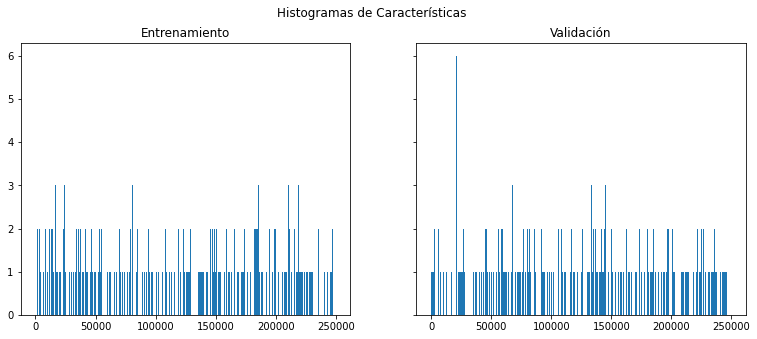

In [28]:
# No recuerdo para qué ploteabamos, pero se ve bonito
plt.show()
fig, axs = plt.subplots(1, 2, figsize=(13, 5), sharey=True)
axs[0].hist(hist,bins=700)
axs[0].set_title('Entrenamiento')
axs[1].hist(hist2,bins=700)
axs[1].set_title('Validación')
fig.suptitle('Histogramas de Características')
plt.show()

---

Ahora sí, hacemos uso de nuestro índice inverso con los datos de **Entrenamiento**

---

In [29]:
#Aquí es donde tardó 6 horas, ahora tarda 4, pero ya termina
# Modifiqué la clase, eliminé los 2 ciclos y logŕe dejar sólo 1
# Probé y funciona, tuve errores en cuanto a que renombre variables y usaba 
# Otras que no estaban definidas, pero me parece que fuera del tiempo
# Logra su cometido.

#Perdón por tanto print, necesitaba ver el anvance para no desesperarme :c
ifs = IndiceInverso()
ifs.Add(bolsas_entrenamiento)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Analizando bolsa: 114
Analizando bolsa: 115
Analizando bolsa: 116
Analizando bolsa: 117
Analizando bolsa: 118
Analizando bolsa: 119
Analizando bolsa: 120
Analizando bolsa: 121
Analizando bolsa: 122
Analizando bolsa: 123
Analizando bolsa: 124
Analizando bolsa: 125
Analizando bolsa: 126
Analizando bolsa: 127
Analizando bolsa: 128
Analizando bolsa: 129
Analizando bolsa: 130
Analizando bolsa: 131
Analizando bolsa: 132
Analizando bolsa: 133
Analizando bolsa: 134
Analizando bolsa: 135
Analizando bolsa: 136
Analizando bolsa: 137
Analizando bolsa: 138
Analizando bolsa: 139
Analizando bolsa: 140
Analizando bolsa: 141
Analizando bolsa: 142
Analizando bolsa: 143
Analizando bolsa: 144
Analizando bolsa: 145
Analizando bolsa: 146
Analizando bolsa: 147
Analizando bolsa: 148
Analizando bolsa: 149
Analizando bolsa: 150
Analizando bolsa: 151
Analizando bolsa: 152
Analizando bolsa: 153
Analizando bolsa: 154
Analizando bolsa: 155
Analizand

---

Observando en qué imágenes está presente la característica 0

---

In [30]:
ifs.__getitem__(0)

La pocisión 0 contiene la característica 129026


[0, 60, 83, 96, 161, 1149, 1307, 1524, 3193, 3197, 3706, 4277, 4279, 4922]

---

De acuerdo a lo que entendí, las búsquedas se realizarían enviando la imagen completa (En este caso, se mandaría la bolsa de características completa), para hacerlo más interesante escogo una imagen al azar para así observar el desempeño del algoritmo de mejor forma

---

In [0]:
consulta = random.randint(0,len(bolsas_entrenamiento)-1)
img_cons = Lista_Entr[consulta]

La imagen de consulta es: paris_general_001844


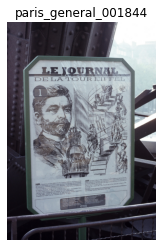

In [32]:
print(f"La imagen de consulta es: {img_cons}")
obten_imagen(img_cons)

---

Usamos el índice inverso para recuperar las que contienen las características de la una consulta ordenados por coincidencias

---

In [0]:
consulta = bolsas_entrenamiento[consulta]

In [0]:
# Este error es lo que comentaba en la celda de indice inverso
# Renombre variables y se me olvidó eliminar las anteriores
# Ya la cambié, pero falta ejecutar, en la mañana lo haré
Parecidos = ifs.recupera(consulta)

---

Como dato cultural muestro la imágen que tuvo más coincidencias

---

In [39]:
mayor = Parecidos.most_common()[1]
mayor

(2319, 82)

In [0]:
mayor = Parecidos.most_common()[1] # Tomamos el 1, porque el 0 es la misma imagen
Index_inv_img = Lista_Entr[mayor[0]]

La imagen con mayor parecido por índice inverso es: paris_general_002769


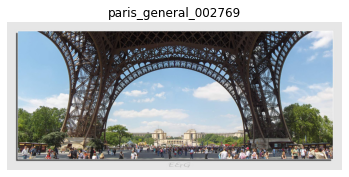

In [41]:
print(f"La imagen con mayor parecido por índice inverso es: {Index_inv_img}")
obten_imagen(Index_inv_img)

---

Ya tenemos las imágenes que se pueden parecer más, ahora bien, me parece que aquellas cuya frecuencia sea igua o menor a 2, es decir sólo hubo a lo mucho 2 características que coincidieron, no pienso que san realmente relevantes, así que los elimino

---

In [47]:
Res = []
comunes = Parecidos.most_common()[1:]#Nuevamente desechamos el primer valor 
print(len(comunes))
k=0
for (_,i) in comunes:
  k+=1
  if i > 2:
    Res.append(comunes[k])

1594


In [46]:
len(Res) # como podemos observar, reducimos en más del 50% los datos a analizar

413

In [45]:
Res[1:4]

[(2543, 81), (2551, 80), (2296, 74)]

---

Ahora sí ya contamos con la lista de imagenes a evaluar en cuanto a distancias, por lo que procedemos a crear una función que nos ayude a evaluar las 3 distancias y retornar el mayor de cada una.

---

In [0]:
def Evalua_distancias(Consulta, Parecidos, lista):
    
    # De acuerdo con las especificaciones del proyecto, debo evaluar
    # con Jaccard, MinMax y Coseno, por lo que eso hace esta función
    # PERO, sólo va a mostar el que tuvo mayor coincidencia de 
    # Cada una de las funciones, es decir, devolverá el más común para 
    # Jaccad, el más común para Coseno y el más común para MinMax

    Jac = []
    Cos = []
    Min = []

    # Calculamos las distancias entre cada uno de ellos
    for (imagen,_) in Parecidos:
      # Calculamos la distancia entre las características de la consulta con las de la imagen parecida
      Cos.append(similitud_coseno(Consulta,lista[imagen])) 
      Jac.append(similitud_jaccard(Consulta,lista[imagen]))
      Min.append(similitud_minmax(Consulta,lista[imagen]))

    Res = []

    #Finalmente crearemos una lista con los máximos de cada uno, devolveremos 3 elementos

    aux = np.argmax(Jac)
    Res.append((aux, Jac[aux]))

    aux = np.argmax(Cos)
    Res.append((aux,Cos[aux]))

    aux = np.argmax(Min)
    Res.append((aux,Min[aux]))

    return Res # Devolvemos la lista con los 3 que tuvieron mayor coincidencia y claro, su valor




---

Lo último que queda es llamarla y mostrar nuestras Imágenes con mayor coincidencia

---

In [0]:
Maximos = Evalua_distancias(consulta,Res,bolsas_entrenamiento)

In [126]:
# Sabemos que tenemos 3 tuplas cuyos valores corresponden a 
# (No. imagen, valor de similitud)
Maximos

[(22, 0.36180904522613067),
 (261, 0.7513367353312126),
 (261, 0.4975759013350502)]

In [0]:
def max_dist(consulta,metodo,maximo,lista,lis):
  print('Se evaluó la imagen:',consulta)
  print("\nLa mayor coincidencia en similitud de",metodo,"fue:",lista[lis[maximo[0]][0]],'\ncon un resultado de:',maximo[1])
  print('\n')
  obten_imagen(lista[lis[maximo[0]][0]])


Se evaluó la imagen: paris_general_001844

La mayor coincidencia en similitud de Coseno fue: paris_museedorsay_000019 
con un resultado de: 0.36180904522613067




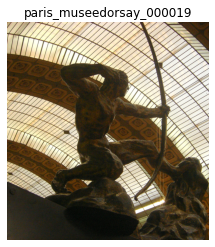

In [143]:
max_dist(img_cons,'Coseno',Maximos[0],Lista_Entr,Res)

Se evaluó la imagen: paris_general_001844

La mayor coincidencia en similitud de Jaccard fue: paris_general_001249 
con un resultado de: 0.7513367353312126




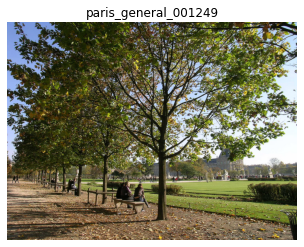

In [144]:
max_dist(img_cons,'Jaccard',Maximos[1],Lista_Entr,Res)

Se evaluó la imagen: paris_general_001844

La mayor coincidencia en similitud de MinMax fue: paris_general_001249 
con un resultado de: 0.4975759013350502




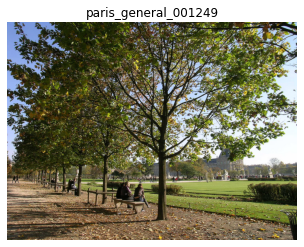

In [145]:
max_dist(img_cons,'MinMax',Maximos[2],Lista_Entr,Res)